In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

import stateinterpreter.MD 

is_reload = True

In [33]:
if is_reload:
    from importlib import reload
    reload(stateinterpreter)
    reload(stateinterpreter.MD)
    reload(stateinterpreter.classifier)

## Loader

In [3]:
from stateinterpreter.MD import Loader

# Paths and filenames
folder = "../md_dataset/chignolin-unbiased/"
colvar_file = folder + 'COLVAR'

traj_dict = {
    'trajectory' : folder+'CLN025-0-protein-ALL.dcd',
    'topology' : folder+'CLN025-0-protein.pdb'
}

# Compute descriptors from traj
data = Loader(colvar_file, kbt=2.827, stride=20)
# Rename TICA CVs
data.colvar = data.colvar.rename(columns={'deep.node-4': 'tica1','deep.node-3': 'tica2','deep.node-2': 'tica3', 'deep.node-1': 'tica4','deep.node-0': 'tica5'})
# Load Trajectory
data.load_trajectory(traj_dict)
# Compute Descriptors
data.compute_descriptors()

## Identify states based on FES minima

In [4]:
# Collective variables used for classes identification
selected_cvs = ['tica1', 'tica2'] # , 'tica3']
bounds = [(-1.1,1.1)]*len(selected_cvs)

# Identify states
data.identify_states(selected_cvs,bounds,fes_cutoff=2*data.kbt,sort_minima=True)

# Prepare inputs
df = data.collect_data()

# Define folder for basins identification (save dataframe and plots)
states_folder = 'results/chignolin-unbiased/tica-2d/'
!mkdir -p {states_folder}

# save dataframe
df.to_csv(states_folder+'dataframe.txt', sep=' ')

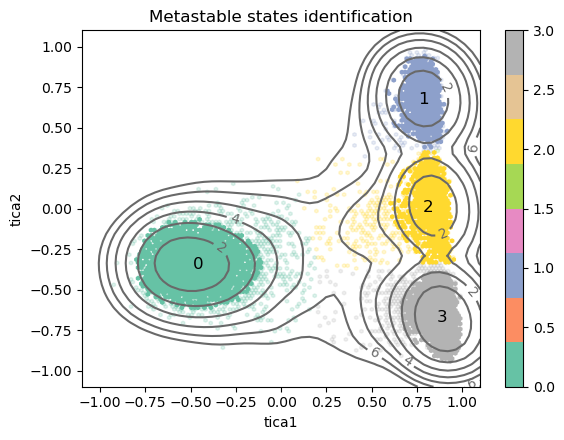

In [61]:
basins = df['basin'].unique()

def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my
    
# scatter plot of tica components 
n_pairs = sum(1 for _ in itertools.combinations(selected_cvs, 2))

fig, axs = plt.subplots(1,n_pairs,figsize=(6*n_pairs,4.5),dpi=100)

for k,(label_x,label_y) in enumerate(itertools.combinations(selected_cvs, 2)):
    # select ax
    ax = axs[k] if n_pairs > 1 else axs

    # FES isolines (if 2D)
    if len(selected_cvs) == 2:
        nx,ny=50,50
        xx, yy = np.meshgrid(np.linspace(bounds[0][0],bounds[0][1],nx),
                             np.linspace(bounds[1][0],bounds[1][1],ny))
        fes = np.zeros_like(xx)
        for i in range(nx):
            for j in range(ny):
                fes[j,i] = data.fes( np.stack([xx[j,i], yy[j,i]]) )
        fes /= data.kbt
        fes -= np.min(fes)
        CS = ax.contour(xx, yy, fes, levels=np.linspace(0,7,8) , colors='dimgrey')

        ax.clabel(CS, CS.levels[::2], inline=True, fontsize=10)

    # hexbin plot
    df.plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax,alpha=0.2,colorbar=False)
    pp = df[df['selection']].plot.hexbin(label_x,label_y,C='basin',cmap='Set2',ax=ax)
    ax.set_title('Metastable states identification')

    #add basins labels
    for b in basins:
        mx,my = compute_basin_mean(df,b,label_x,label_y)
        text = ax.text(mx, my, b, ha="center", va="center", 
                       color="k", fontsize='large')

plt.savefig(states_folder+'states.png',bbox_inches='tight')
plt.tight_layout()

## Stateinterpreter

In [36]:
from stateinterpreter.classifier import MD_Data, CV_path

states_folder = 'results/chignolin-unbiased/tica-2d/'

# Load input from file
#colvar = pd.read_csv(states_folder+'dataframe.txt', sep=' ')
# or directly from dataframe
model = MD_Data(df)

# input features
select_feat = 'HB_CONTACT' #|sin_|cos_'
sample = model.sample(1000, regex_filter = select_feat)

# Define results folder (save plots and results)
save_results = True
results_folder = states_folder + 'hbonds/'
!mkdir -p {results_folder}

In [37]:
# plot cvpath and print info about features
def get_relevant_features(cvpath, C, save_results, results_folder, base_prefix='linear'):

    print('\n-- RELEVANT FEATURES --')
    # print features per state
    cvpath.print_relevant_features(C)

    # unique features
    relevant_feat = cvpath.relevant_features(C)

    unique_features = set()
    for state in relevant_feat.values():
        for feat in state:
            unique_features.add(feat[1])
    unique_features = list(unique_features)

    #sort based on residue #TODO this works only for angles, generalize or change features names
    #unique_features.sort(key=lambda x: int(x[-1]))

    print('\n-- UNIQUE FEATURES --')
    for feat in unique_features:
        print(feat)

    # save to file
    if save_results:
        with open(results_folder+base_prefix+'-features.txt', 'w') as f:
            print('\n-- RELEVANT FEATURES --',file=f)
            cvpath.print_relevant_features(C,file=f)
            print('\n-- UNIQUE FEATURES --',file=f)
            for feat in unique_features:
                print(feat,file=f)

    return relevant_feat, unique_features

In [38]:
# aux function to compute basins mean
def compute_basin_mean(df, basin, label_x, label_y):
    mx = df[df['basin'] == basin][label_x].mean()
    my = df[df['basin'] == basin][label_y].mean()
    return mx,my

# color CVs space by TICA
def plot_CVs_space(colvar, cv_x, cv_y, relevant_feat, max_nfeat = 3):

    # retrieve basins
    basins = colvar['basin'].unique()
    n_basins = len(basins)

    fig, axs = plt.subplots(n_basins,max_nfeat,figsize=(6 * max_nfeat, 5* n_basins),dpi=100, )
                            #sharex=True, sharey=True)

    # for each state ...
    for i,(state,feat_list) in enumerate(relevant_feat.items()):
        # ... color with the corresponding features ...
        for j,feat_array in enumerate(feat_list):
            # ... up to max_nfeat plot per state
            if j < max_nfeat:
                feat = feat_array[1]
                importance = feat_array[2]
                ax = axs[i,j]
                pp = colvar[colvar['selection']==1].plot.hexbin(cv_x,cv_y,C=feat,cmap='coolwarm',ax=ax)
                #set title
                ax.set_title(f'[state {state}] {feat} - {np.round(importance*100)}%')
                #add basins labels
                for b in basins:
                    mx,my = compute_basin_mean(colvar,b,cv_x,cv_y)
                    bcolor = 'k' if b == i else 'w'
                    fcolor = 'w' if b == i else 'k'            
                    ax.scatter(mx,my,color=bcolor,s=250,alpha=0.7)
                    text = ax.text(mx, my, b, ha="center", va="center", 
                                color=fcolor, fontsize='large')
        
        #set labels
        for ax in plt.gcf().axes:
            try:
                ax.label_outer()
            except:
                pass

        #disable unused axis
        for j in range(len(feat_list),max_nfeat):
            axs[i,j].axis('off')

    plt.tight_layout()

### Linear Kernel

In [52]:
C_range = np.geomspace(1, 100, 25)
kwargs = {'LASSO':True, 'max_iter':10000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

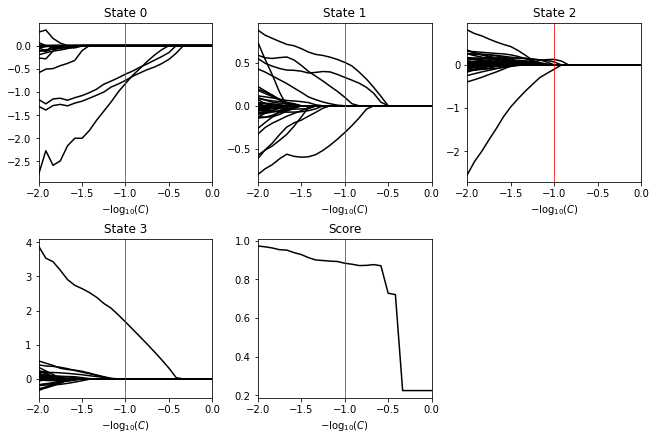


-- RELEVANT FEATURES --
State 0:
	 41.5%  | HB_CONTACT ASP3-O -- GLY7-N
	 35.1%  | HB_CONTACT TYR1-O -- TYR10-N
	 23.4%  | HB_CONTACT ASP3-N -- THR8-O
State 1:
	 54.1%  | HB_CONTACT THR8-OG1s -- TRP9-O
	 23.2%  | HB_CONTACT THR8-OG1s -- TRP9-N
	 20.6%  | HB_CONTACT THR6-OG1s -- GLY7-N
	 2.1%   | HB_CONTACT ASP3-N -- TYR10-N
State 2:
	 53.7%  | HB_CONTACT ASP3-O -- GLY7-N
	 30.5%  | HB_CONTACT THR6-OG1s -- THR8-OG1s
	 15.8%  | HB_CONTACT TYR1-O -- TYR10-N
State 3:
	 100.0% | HB_CONTACT THR6-OG1s -- THR8-OG1s

-- UNIQUE FEATURES --
HB_CONTACT THR6-OG1s -- THR8-OG1s
HB_CONTACT THR8-OG1s -- TRP9-O
HB_CONTACT ASP3-N -- TYR10-N
HB_CONTACT THR6-OG1s -- GLY7-N
HB_CONTACT ASP3-O -- GLY7-N
HB_CONTACT THR8-OG1s -- TRP9-N
HB_CONTACT ASP3-N -- THR8-O
HB_CONTACT TYR1-O -- TYR10-N


In [53]:
C = np.power(10,1)

# PLOT
base_prefix = 'linear'
cvpath.plot(C)
if save_results:
    plt.savefig(results_folder+base_prefix+'-cvpath.png',
            facecolor='w', 
            transparent=False,
            bbox_inches='tight')
plt.show()

# RELEVANT FEATURES
relevant_feat, unique_features = get_relevant_features(cvpath,C,save_results,results_folder,base_prefix=base_prefix)

1
0 tica1 tica2


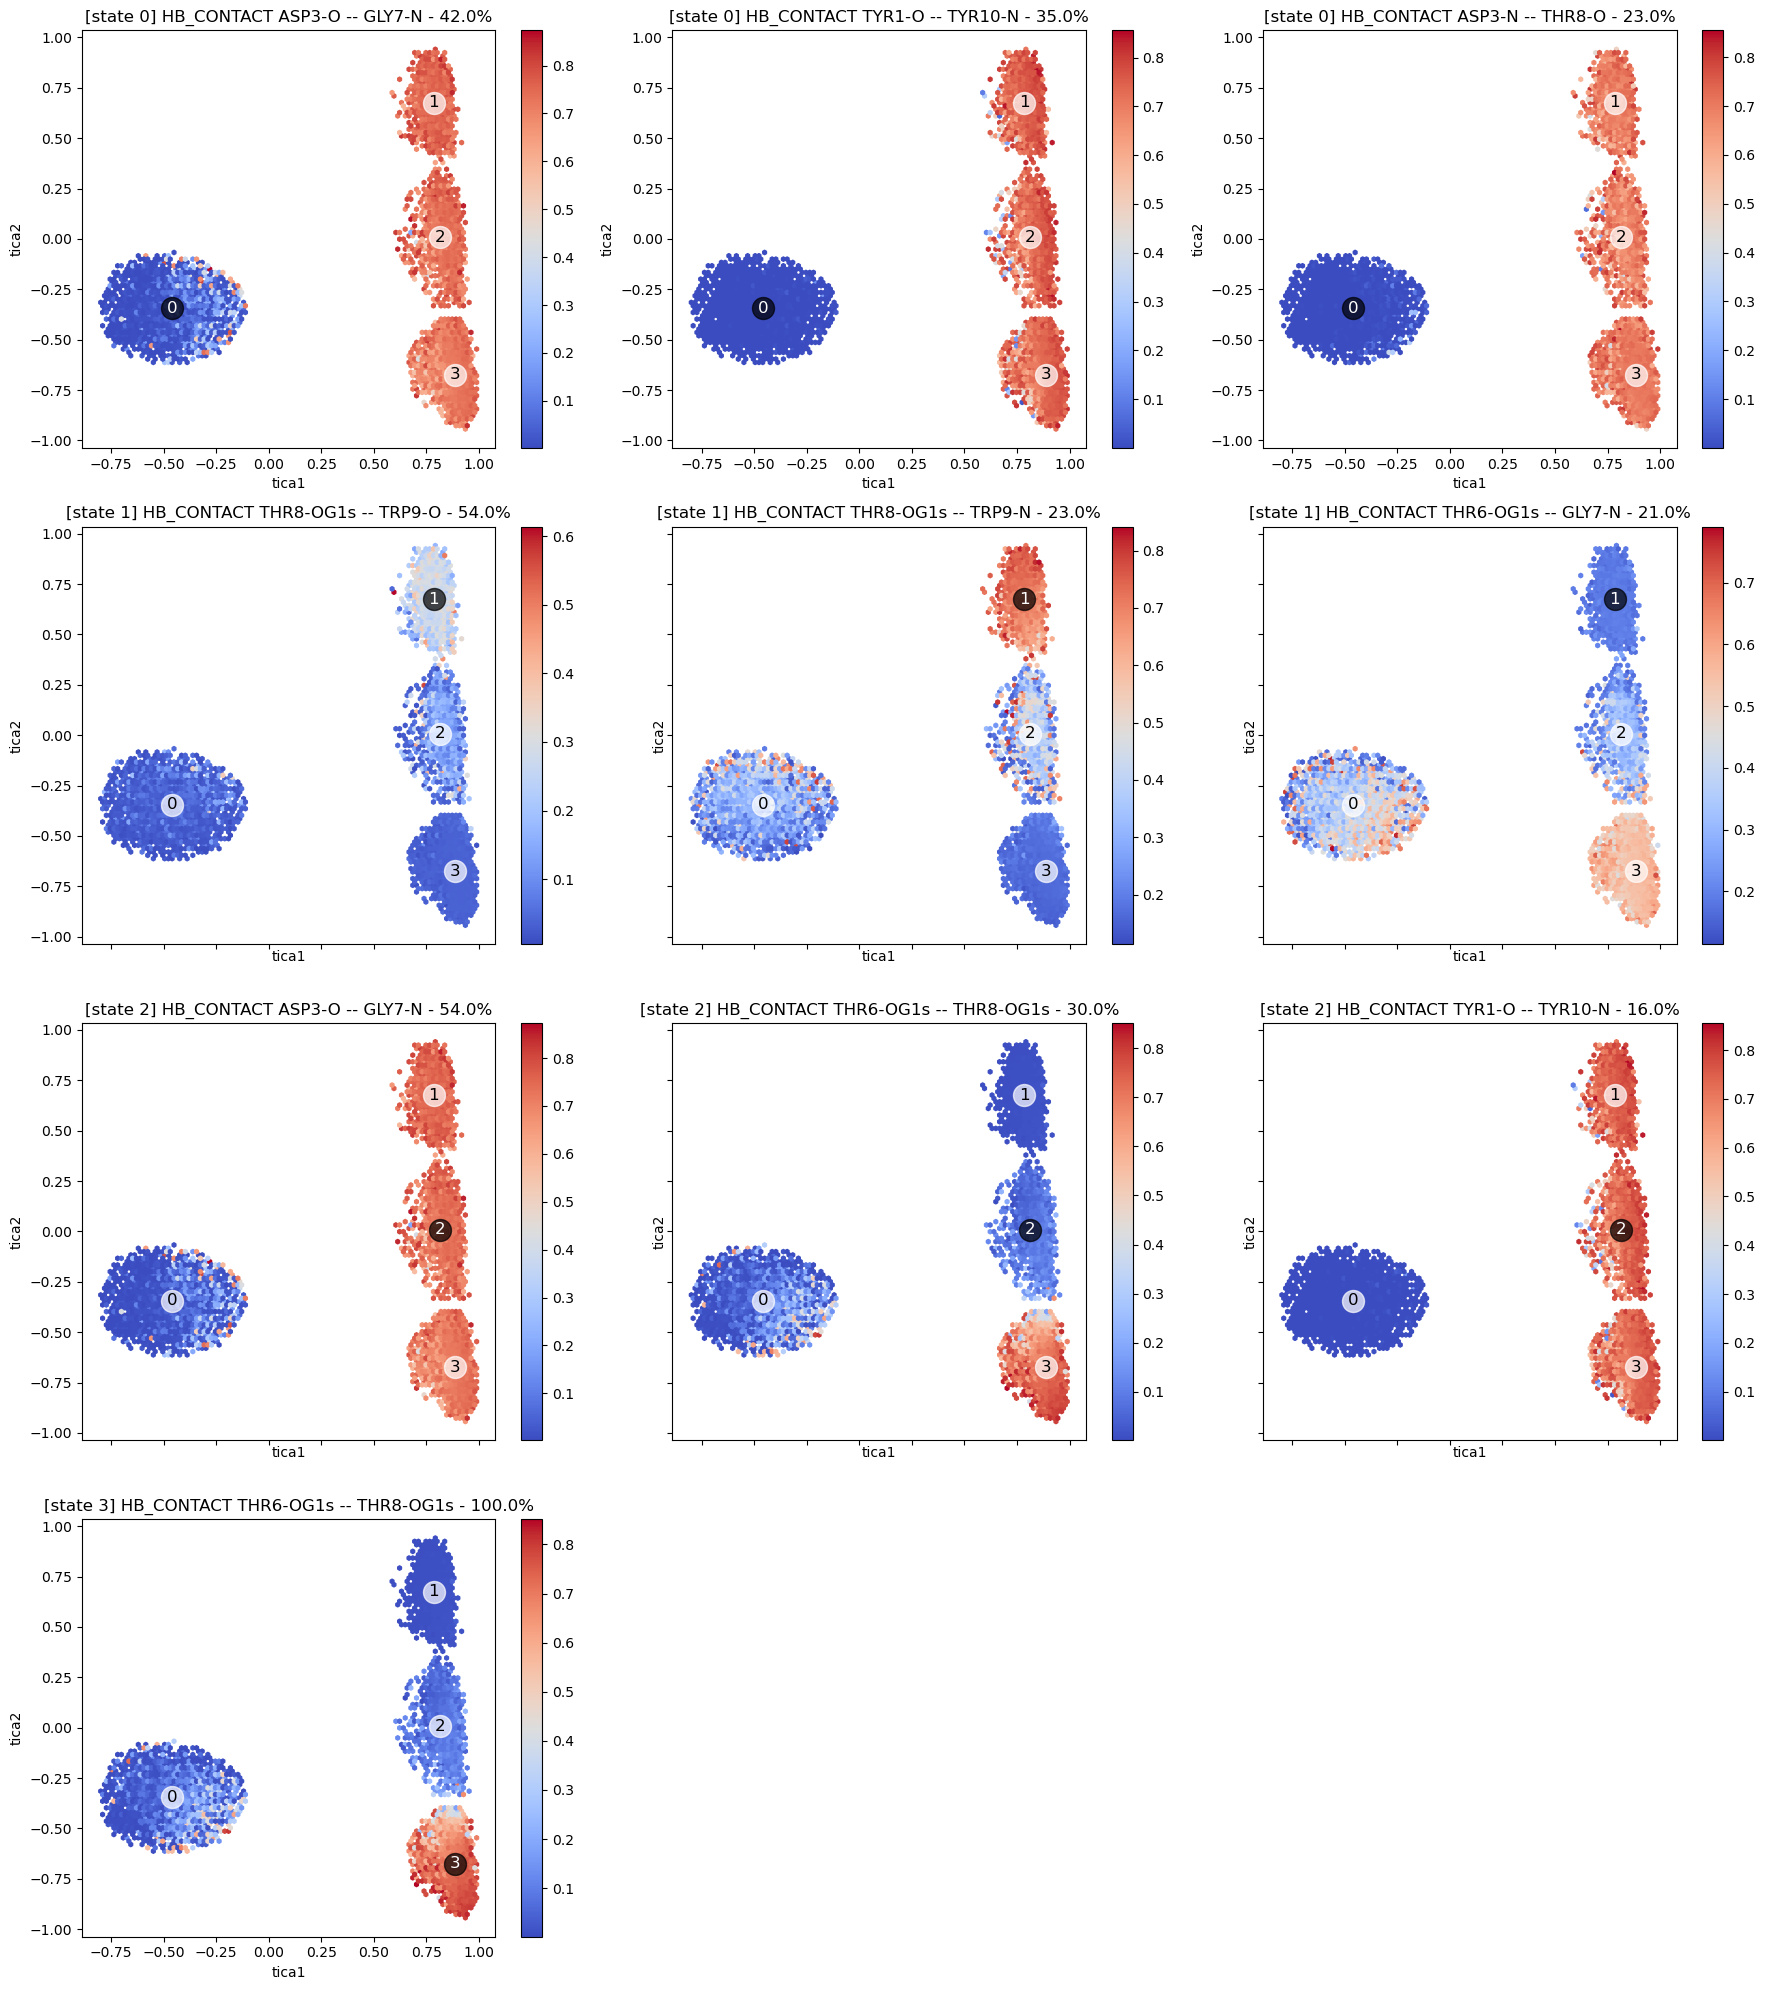

In [54]:
pairs = itertools.combinations(selected_cvs, 2)
n_pairs = sum(1 for _ in pairs)
print(n_pairs)

for k,(cv_x,cv_y) in  enumerate(itertools.combinations(selected_cvs, 2)):
    print(k,cv_x,cv_y)

    plot_CVs_space(df, cv_x, cv_y, relevant_feat, max_nfeat = 3)

    if save_results:
        plt.savefig(results_folder+base_prefix+f'-relevant_feats{k+1 if n_pairs > 1 else None}.png',
                    facecolor='w', 
                    transparent=False,
                    bbox_inches='tight')
    plt.show()

### Quadratic kernel

In [55]:
# Create quadratic Kernel based on features selected with C value above

prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);


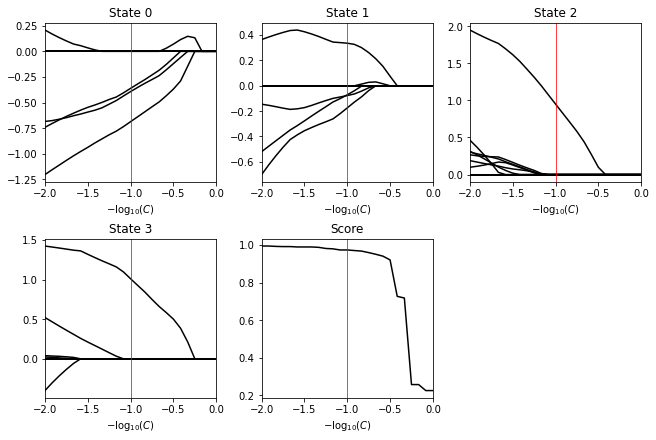


-- RELEVANT FEATURES --
State 0:
	 62.3%  | HB_CONTACT TYR1-O -- TYR10-N
	 20.4%  | HB_CONTACT ASP3-N -- THR8-O
	 17.3%  | HB_CONTACT ASP3-O -- GLY7-N
State 1:
	 73.1%  | HB_CONTACT THR8-OG1s -- TRP9-N
	 19.7%  | HB_CONTACT THR8-OG1s -- TRP9-N || HB_CONTACT THR6-OG1s -- GLY7-N
	 3.9%   | HB_CONTACT THR8-OG1s -- TRP9-O || HB_CONTACT THR6-OG1s -- GLY7-N
	 3.3%   | HB_CONTACT THR6-OG1s -- GLY7-N
State 2:
	 100.0% | HB_CONTACT THR8-OG1s -- TRP9-N || HB_CONTACT THR6-OG1s -- GLY7-N
State 3:
	 100.0% | HB_CONTACT THR6-OG1s -- THR8-OG1s

-- UNIQUE FEATURES --
HB_CONTACT THR6-OG1s -- THR8-OG1s
HB_CONTACT THR8-OG1s -- TRP9-N || HB_CONTACT THR6-OG1s -- GLY7-N
HB_CONTACT THR8-OG1s -- TRP9-O || HB_CONTACT THR6-OG1s -- GLY7-N
HB_CONTACT THR6-OG1s -- GLY7-N
HB_CONTACT ASP3-O -- GLY7-N
HB_CONTACT THR8-OG1s -- TRP9-N
HB_CONTACT ASP3-N -- THR8-O
HB_CONTACT TYR1-O -- TYR10-N


In [56]:
C = np.power(10,1)

# PLOT
base_prefix = 'pruned'
prunedcv.plot(C)
if save_results:
    plt.savefig(results_folder+base_prefix+'-cvpath.png',
            facecolor='w', 
            transparent=False,
            bbox_inches='tight')
plt.show()

# RELEVANT FEATURES
relevant_feat, unique_features = get_relevant_features(prunedcv,C,save_results,results_folder,base_prefix=base_prefix)

In [57]:
# add quadratic features to dataframe
for feat in unique_features:
    if "||" in feat:
        if feat not in df.columns: 
            i, j = feat.split(' || ')
            feat_ij = df[i].values * df[j].values
            df[feat] = feat_ij

1
0 tica1 tica2


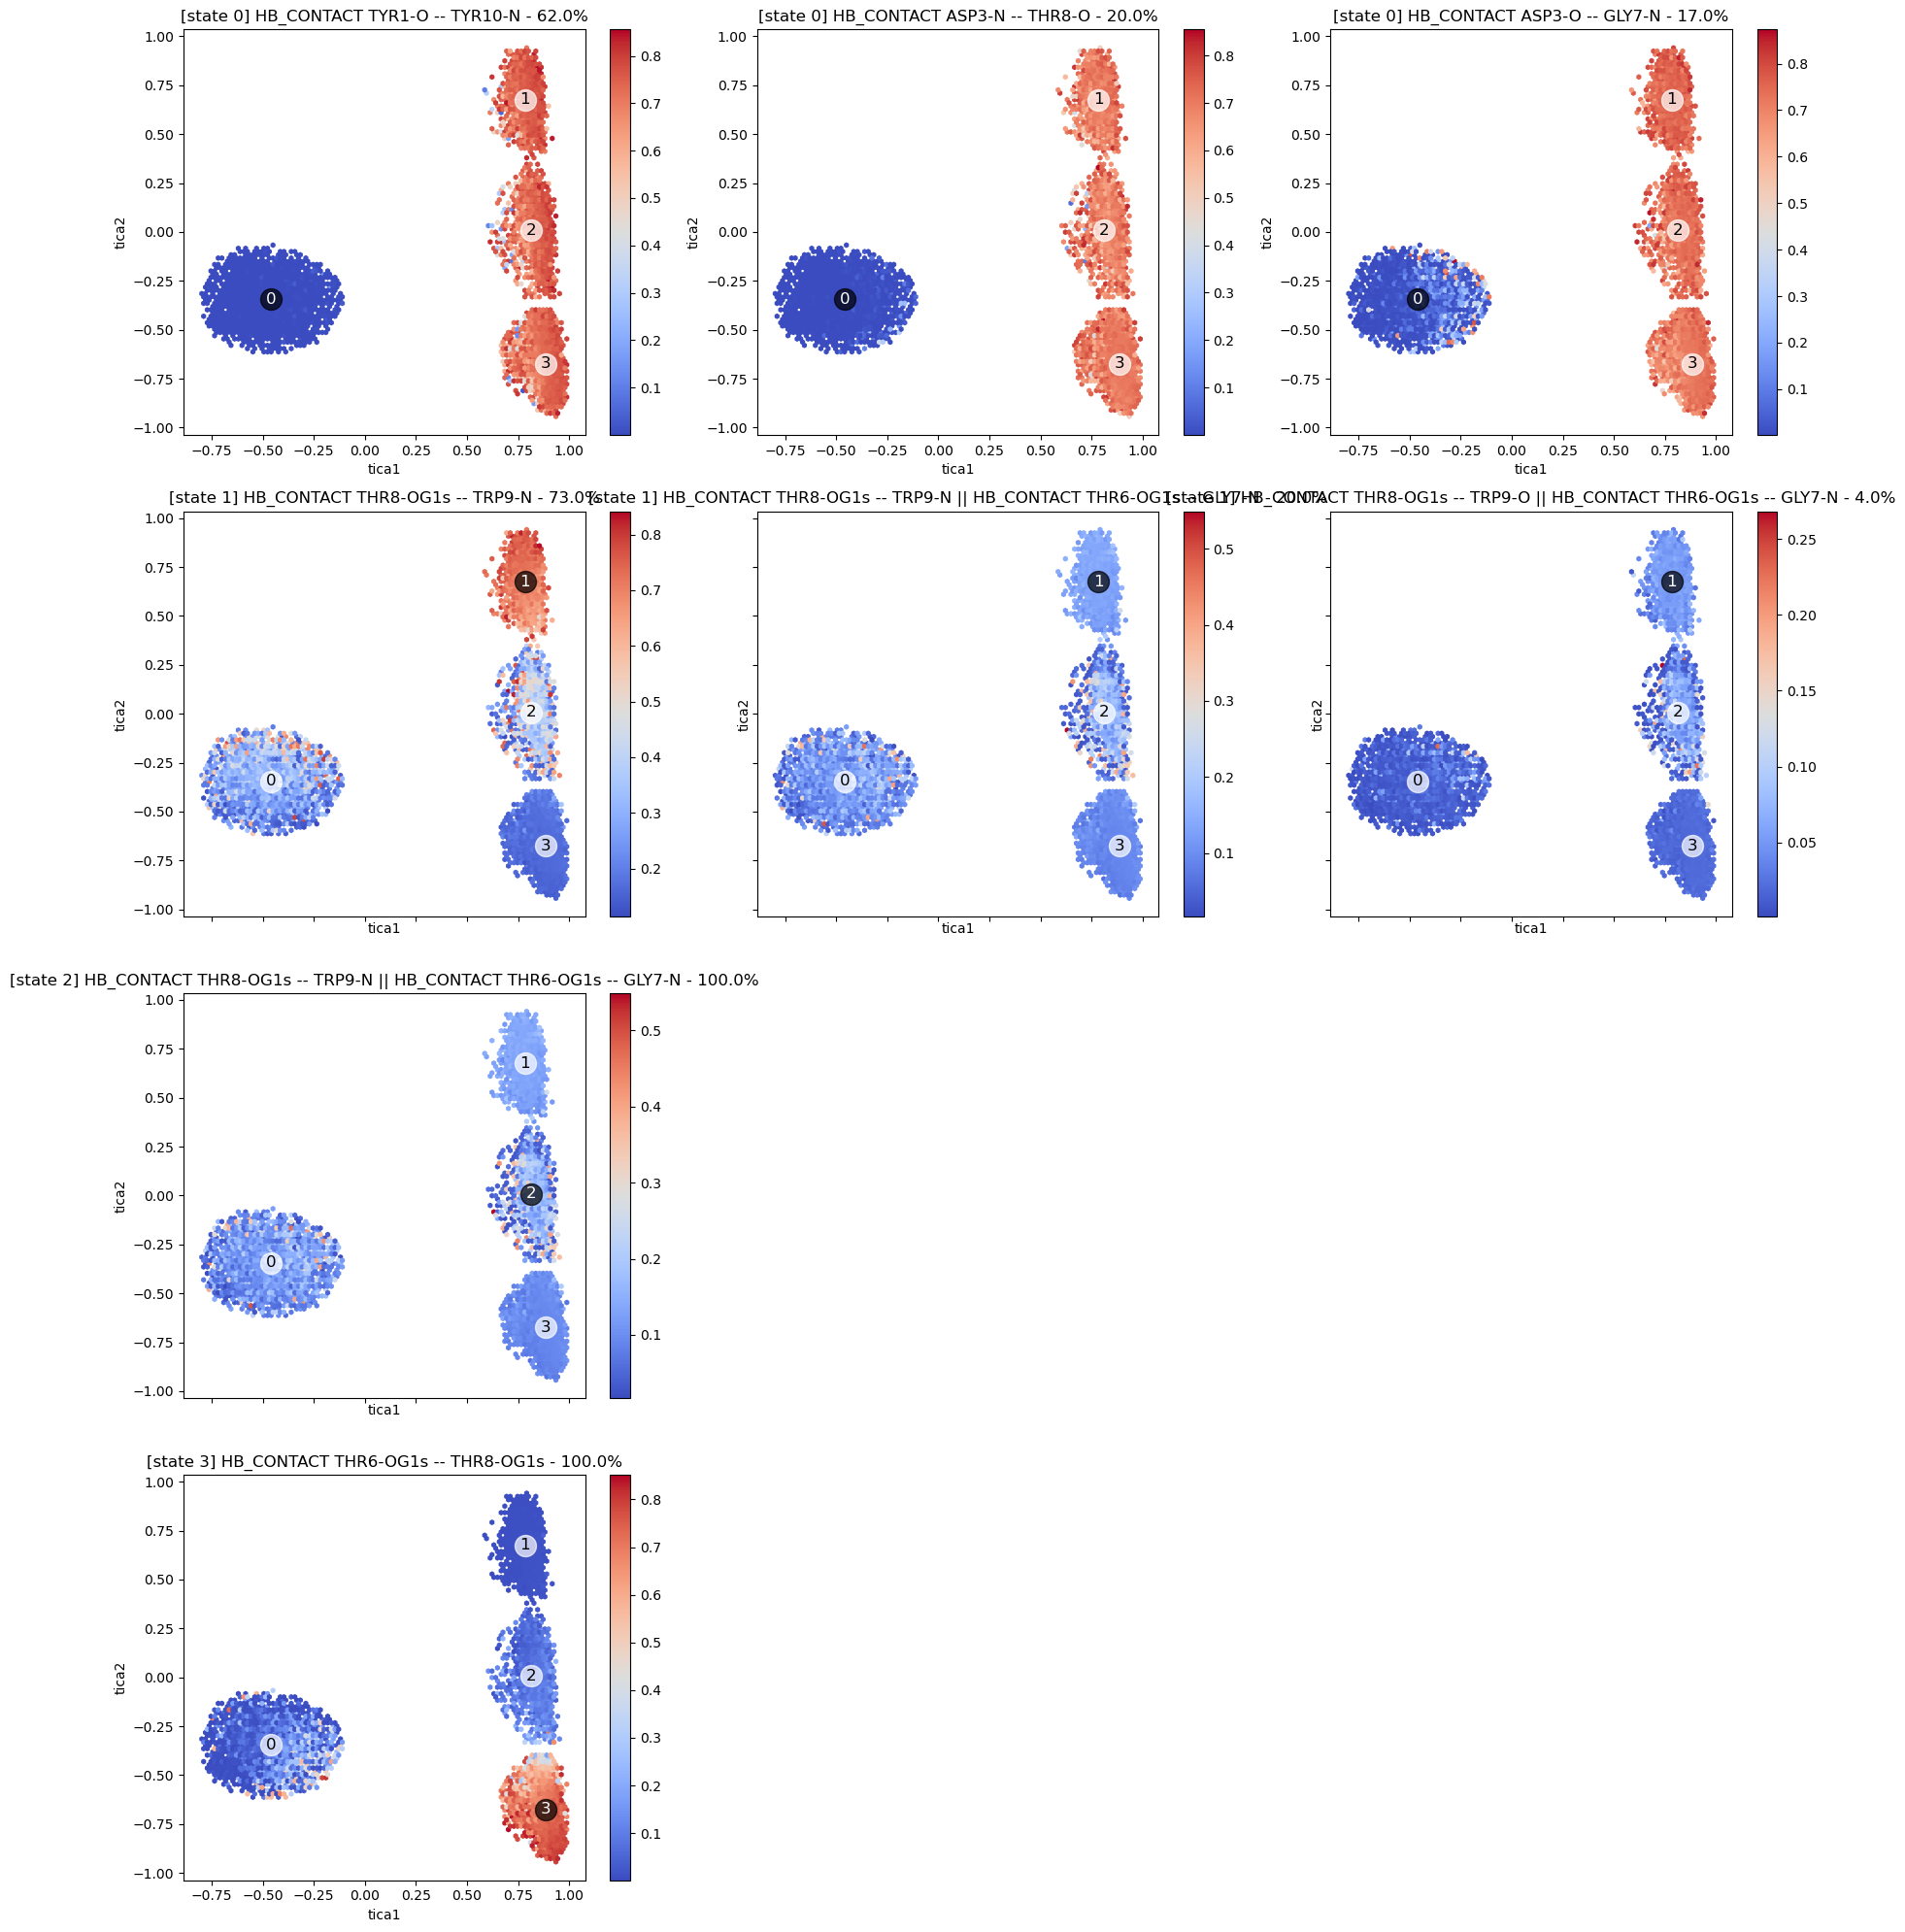

In [60]:
pairs = itertools.combinations(selected_cvs, 2)
n_pairs = sum(1 for _ in pairs)
print(n_pairs)

for k,(cv_x,cv_y) in  enumerate(itertools.combinations(selected_cvs, 2)):
    print(k,cv_x,cv_y)

    plot_CVs_space(df, cv_x, cv_y, relevant_feat, max_nfeat = 3)

    if save_results:
        plt.savefig(results_folder+base_prefix+f'-relevant_feats{k+1 if n_pairs > 1 else None}.png',
                    facecolor='w', 
                    transparent=False,
                    bbox_inches='tight')
    plt.show()